# 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import csv
import warnings
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,classification_report, confusion_matrix

# 2. Data Load & Normalization

In [2]:
#Define Functions to create connections and tables 

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    conn = sqlite3.connect(db_file)
    return conn

def create_table(conn, create_table_sql):
        c = conn.cursor()
        c.execute(create_table_sql)

In [3]:
#Define csv file path
non_normalized_db_filename = "C:/Users/satya/Downloads/Bank_Customer_Churn_Prediction.csv"

#Create connections
conn = create_connection('normalized.db')

#Extract customer columns and credit card columns 
credit_card_data = []
customer_data = []
credit_card_columns = ['customer_id', 'credit_card']
customer_columns = ['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
                     'products_number', 'active_member', 'estimated_salary', 'churn']


#Extract Customer data
with open(non_normalized_db_filename, 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        row_data = tuple(row[column] for column in customer_columns)
        customer_data.append(row_data)
        
#Extract credit card data
with open(non_normalized_db_filename, 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        row_data = (row['customer_id'], row['credit_card'])
        credit_card_data.append(row_data)
        

drop_sql = """DROP TABLE IF EXISTS customer_churn_data"""
create_table(conn, drop_sql)

#Create tables for customer and credit card data

create_table_sql = """CREATE TABLE customer_churn_data (
    customer_id INT PRIMARY KEY,
    credit_score INT,
    country VARCHAR(255),
    gender VARCHAR(50),
    age INT,
    tenure INT,
    balance FLOAT,
    products_number INT,
    active_member BOOLEAN,
    estimated_salary FLOAT,
    churn BOOLEAN
);
"""

create_credit_card_table_sql = """
CREATE TABLE IF NOT EXISTS credit_cards (
    customer_id INT PRIMARY KEY,
    credit_card BOOLEAN,
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
);
"""

create_table(conn, create_table_sql)
create_table(conn, create_credit_card_table_sql)


#Insert extracted data into newly created tables
conn.executemany(f'INSERT or IGNORE INTO customer_churn_data VALUES ({",".join(["?"] * len(customer_columns))})', customer_data)
conn.executemany(f'INSERT or IGNORE INTO credit_cards VALUES (?, ?)', credit_card_data)
    
#Join the two tables to create one master data set
query = """SELECT c.*, cc.credit_card FROM customer_churn_data c JOIN credit_cards cc ON c.customer_id = cc.customer_id"""

customer_churn_data = pd.read_sql_query(query, conn)

conn.commit()
conn.close()

customer_churn_data = customer_churn_data.drop(customer_churn_data.index[0])

customer_churn_data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,active_member,estimated_salary,churn,credit_card
1,15647311,608,Spain,Female,41,1,83807.86,1,1,112542.58,0,0
2,15619304,502,France,Female,42,8,159660.80,3,0,113931.57,1,1
3,15701354,699,France,Female,39,1,0.00,2,0,93826.63,0,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,79084.10,0,1
5,15574012,645,Spain,Male,44,8,113755.78,2,0,149756.71,1,1


# 3. Exploratory Data Analysis

This dataset has 9999 rows and 12 columns

In [4]:
#Number of rows and columns in data
customer_churn_data.shape

(9999, 12)

There are no null values in the dataset

In [5]:
#Check for null values in each column
customer_churn_data.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
active_member       0
estimated_salary    0
churn               0
credit_card         0
dtype: int64

In [6]:
#Check Unioque values in each column
customer_churn_data.nunique()

customer_id         9999
credit_score         460
country                3
gender                 2
age                   70
tenure                11
balance             6382
products_number        4
active_member          2
estimated_salary    9998
churn                  2
credit_card            2
dtype: int64

In [7]:
#Data types of each column
customer_churn_data.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
active_member         int64
estimated_salary    float64
churn                 int64
credit_card           int64
dtype: object

In [8]:
#Data Statistics/Summary

columns = ['age', 'balance', 'estimated_salary','credit_score']
summary_stats = customer_churn_data[columns].describe().round(2)
summary_stats

,age,balance,estimated_salary,credit_score
count,9999.00,9999.00,9999.00,9999.00
mean,38.92,76493.54,100090.11,650.53
std,10.49,62395.84,57513.37,96.66
min,18.00,0.00,11.58,350.00
25%,32.00,0.00,50992.93,584.00
50%,37.00,97208.46,100187.43,652.00
75%,44.00,127646.04,149392.06,718.00
max,92.00,250898.09,199992.48,850.00


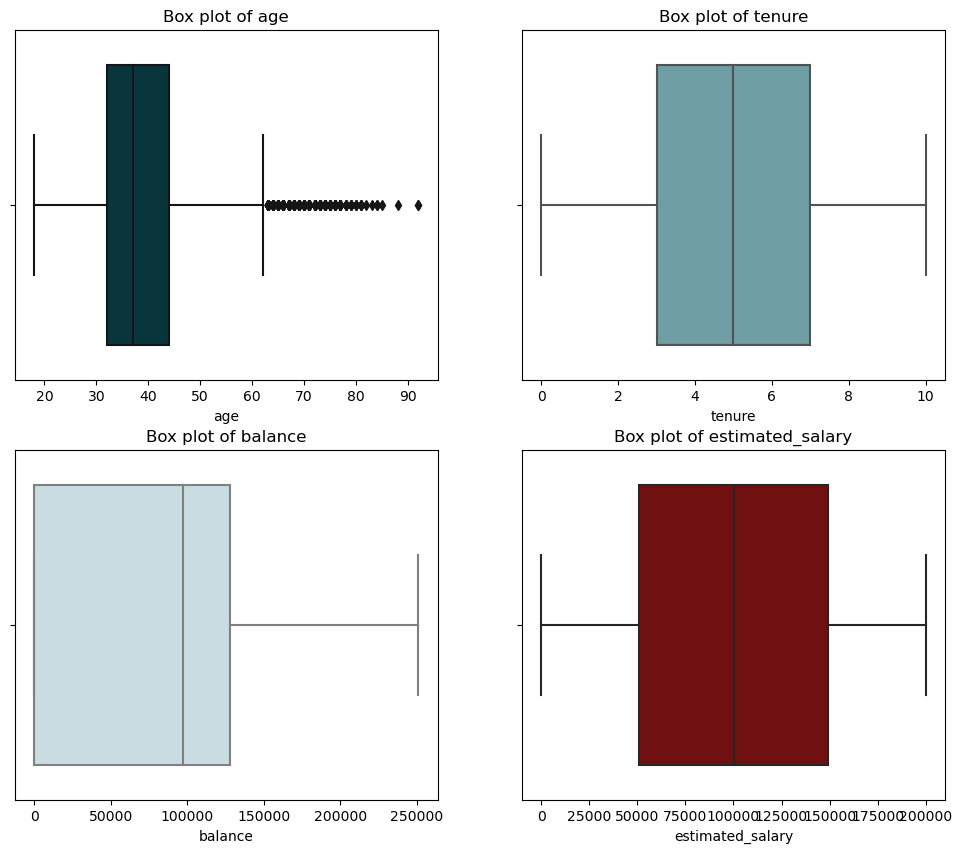

In [9]:
#check for outliers in columns: Tenure,Balance,age and estimated salary

palette = ["#003b46", "#66a5ad", "#c4dfe6", "#800000","#f59e0b", "#fcb646"]
selected_colors = palette[:4]
columns_to_check = ['age', 'tenure', 'balance', 'estimated_salary']
plt.figure(figsize=(12, 10))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=customer_churn_data[column], color=selected_colors[i-1])
    plt.title(f'Box plot of {column}')
plt.show()


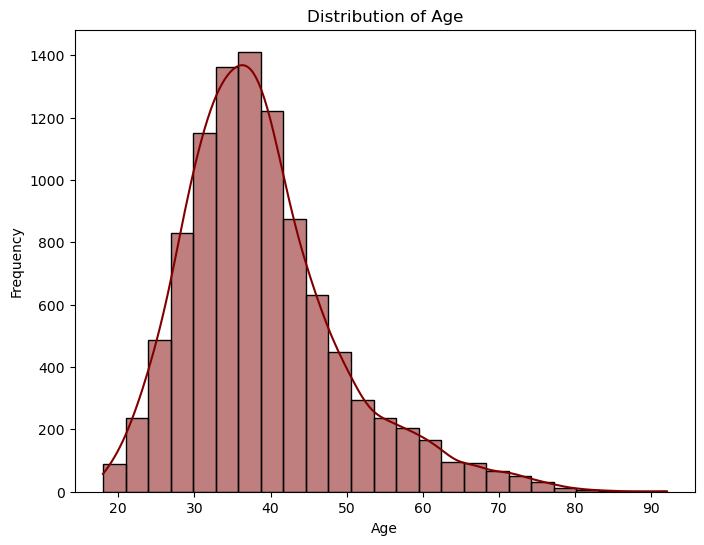

In [10]:
#Check distribution of age to see if the outliers shown in box plot are actually outliers 

plt.figure(figsize=(8, 6))
sns.histplot(customer_churn_data['age'], bins=25, kde=True, color="#800000")  
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

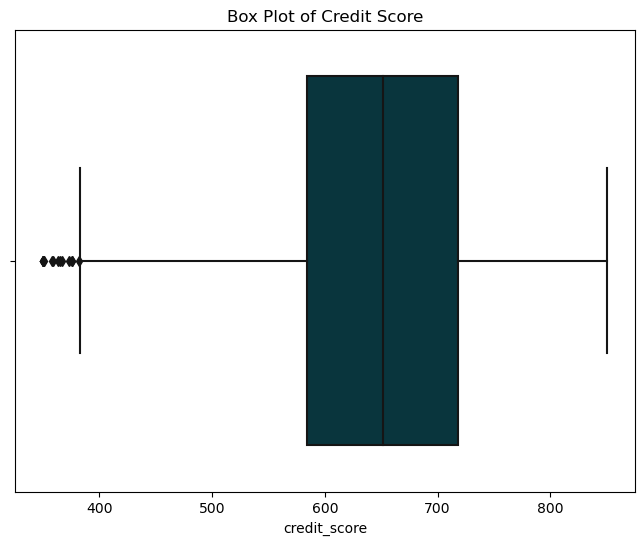

In [11]:
#check if credit score column has outliers

palette = ["#003b46", "#66a5ad", "#c4dfe6", "#800000","#f59e0b", "#fcb646"]
plt.figure(figsize=(8, 6))
sns.boxplot(x='credit_score', data=customer_churn_data,palette = palette)
plt.title('Box Plot of Credit Score')
plt.show()

In [12]:
#Check min and max values of credit score to figure if outliers actually exist in the column

min_score = customer_churn_data['credit_score'].min()
max_score = customer_churn_data['credit_score'].max()

print(min_score)
print(max_score)

350
850


# 3.1 Univariate Analysis

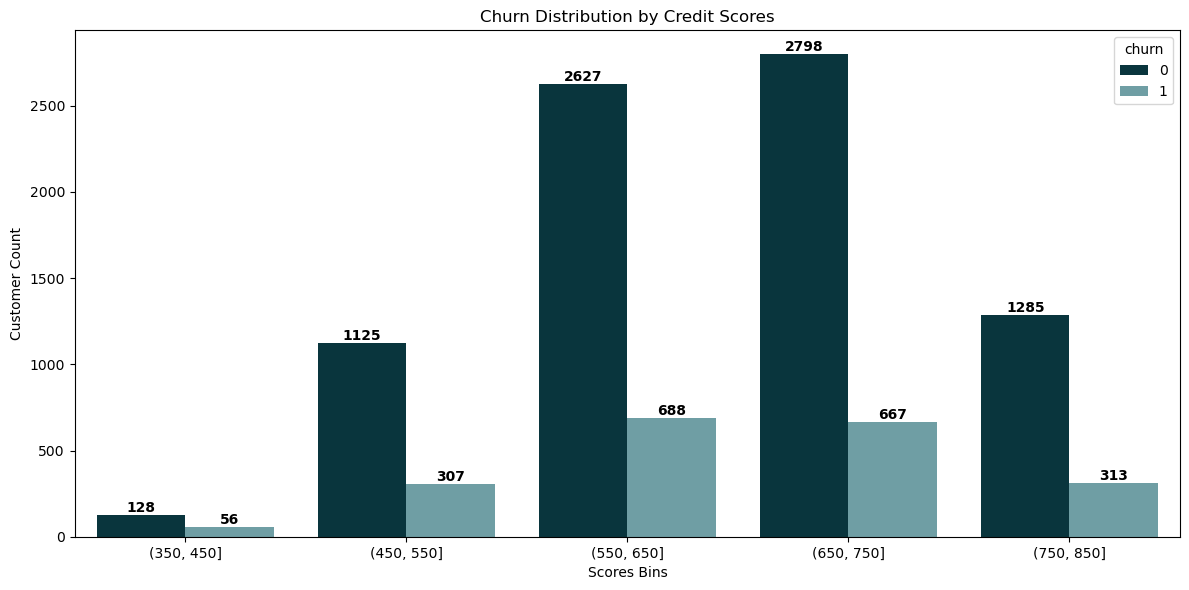

In [13]:
#Credit Score vs customer churn count

bins = [350, 450, 550, 650, 750, 850]
palette = ["#003b46","#66a5ad","#800000", "#c4dfe6","#f59e0b", "#fcb646"]

customer_churn_data['scores_bin'] = pd.cut(customer_churn_data['credit_score'], bins=bins)

# Bar plot for churn distribution within each score bin
plt.figure(figsize=(12, 6))
ax=sns.countplot(x='scores_bin', hue='churn', data=customer_churn_data,palette = palette)
plt.title('Churn Distribution by Credit Scores')
plt.xlabel('Scores Bins')
plt.ylabel('Customer Count')
plt.legend(title='churn', loc='upper right')
plt.tight_layout()

# Annotate each bar with count and percentage in brackets
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')

plt.show()

Observations: 

1. The overall churn rate appears to be relatively low, with the "no churn" bar dominating across all credit score buckets.
2. However churn rate is relatively higher (~30%) in lower credit score buckets 

Insight:

1. Competitors might offer more attractive deals or promotions to customers with lower credit scores, incentivizing them to        switch providers

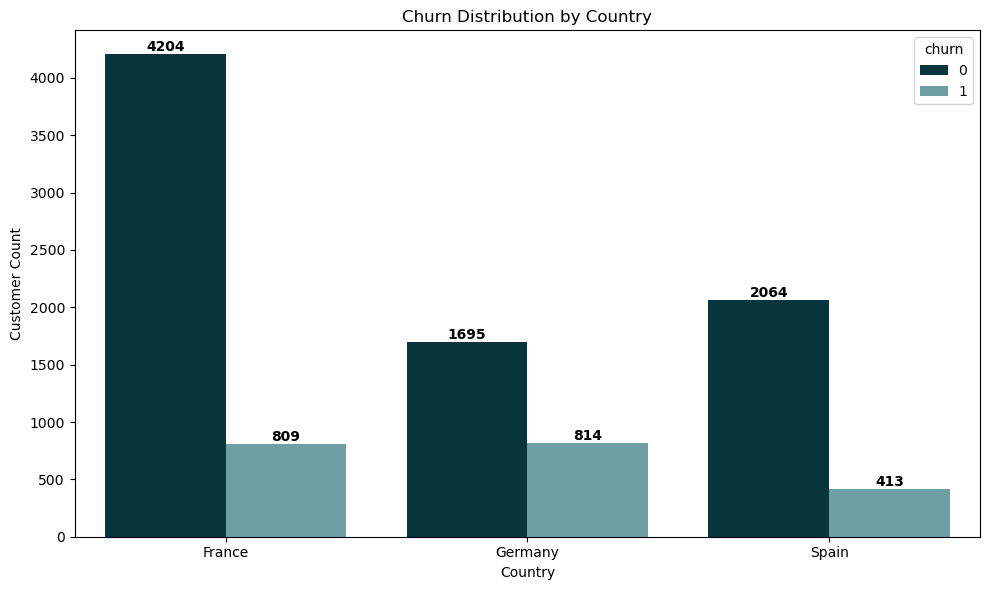

In [14]:
#Country vs customer churn count

palette = ["#003b46","#66a5ad", "#800000","#c4dfe6","#f59e0b", "#fcb646"]
churn_count_by_country = customer_churn_data.groupby('country')['churn'].value_counts().rename('count').reset_index()

# Bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='country', y='count', hue='churn', data=churn_count_by_country,palette = palette)
plt.title('Churn Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Customer Count')
plt.legend(title='churn', loc='upper right')
plt.tight_layout()

# Annotate each bar with count only
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')
    
plt.show()

Observations: 

1. Although Overall customer count is higher in France, Attrition rate is higher in Germany (~32.4%)

Insight:

1. There could be several factors causing this - In Germany, Customer satisfaction could be lower and promotional activities        could be less aggressive 

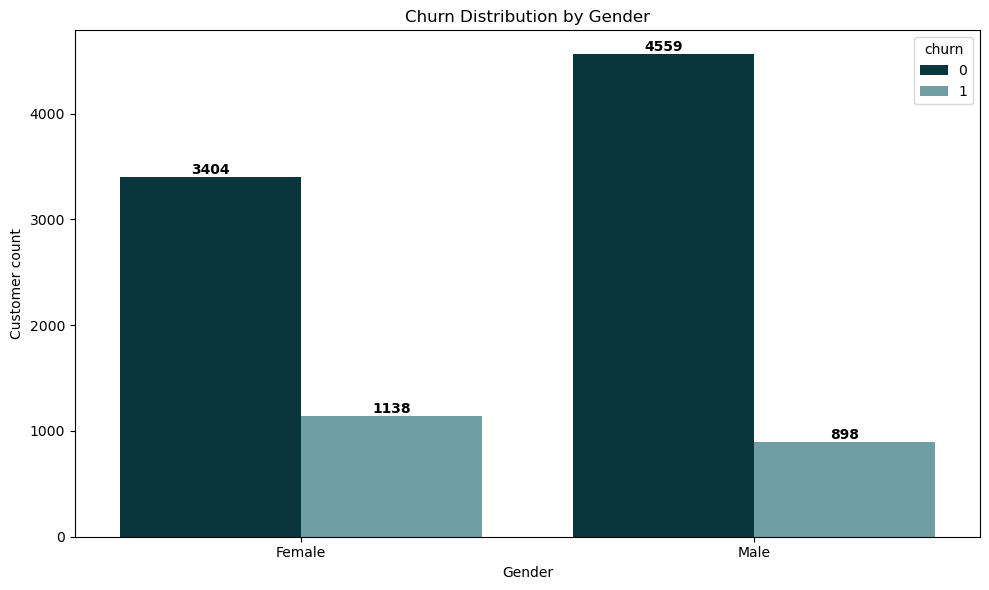

In [15]:
#Gender vs customer churn count

palette = ["#003b46","#66a5ad", "#800000","#c4dfe6","#f59e0b", "#fcb646"]
churn_count_by_gender = customer_churn_data.groupby('gender')['churn'].value_counts().rename('count').reset_index()

# Bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='gender', y='count', hue='churn', data=churn_count_by_gender, palette =palette)
plt.title('Churn Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Customer count')
plt.legend(title='churn', loc='upper right')
plt.tight_layout()

# Annotate each bar with count only
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')
    

plt.show()

Observations: 

1. Male customers are higher in number when compared to female customers 
2. But churn rate is seen in female customers (~25% which is about ~9% greater than that of male customers) 

Insight:

1. Marketing and messaging could be more appealing to male customers and service satisfaction could be less in female customers 

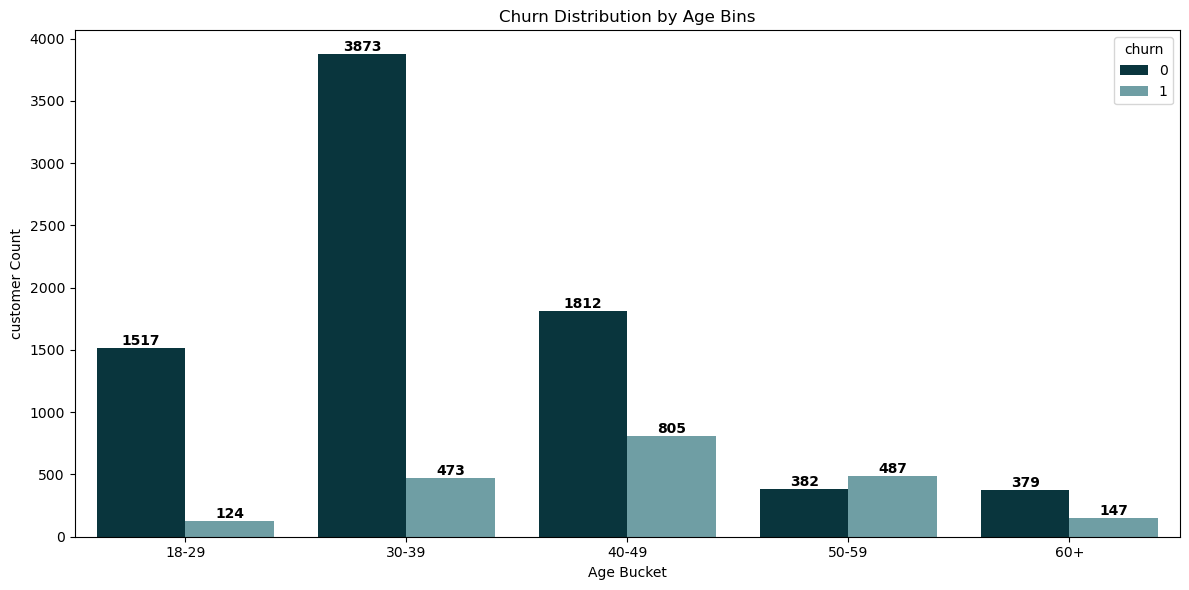

In [16]:
#Age vs customer churn count

palette = ["#003b46","#66a5ad", "#800000","#c4dfe6","#f59e0b", "#fcb646"]
bins = [18, 30, 40, 50, 60, 100] 
labels = ['18-29', '30-39', '40-49', '50-59', '60+'] 
customer_churn_data['age_bucket'] = pd.cut(customer_churn_data['age'], bins=bins, labels=labels, right=False)

# Bar plot for churn distribution within each age bin
plt.figure(figsize=(12, 6))
ax =sns.countplot(x='age_bucket', hue='churn', data=customer_churn_data,palette = palette)
plt.title('Churn Distribution by Age Bins')
plt.xlabel('Age Bucket')
plt.ylabel('customer Count')
plt.legend(title='churn', loc='upper right')
plt.tight_layout()

# Annotate each bar with count only
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')
    
plt.show()


Observations: 

1. Customers in the age range 30-39 were in the majority when compared to those of other ages 
2. Interestingly, the number of customers in the range of 40-49 and 50-59 have higher attrition rates (~30% and ~56%                respectively)
   when compared to young customers 
   
Insight:

1. Usually old customers are loyal but it's not true in this case as they could be finding it difficult to adopt digitally savvy    solutions and switching to providers who offer better in-person banking service
2. Competitors might target them with tailored offers for retirement-specific products or services 

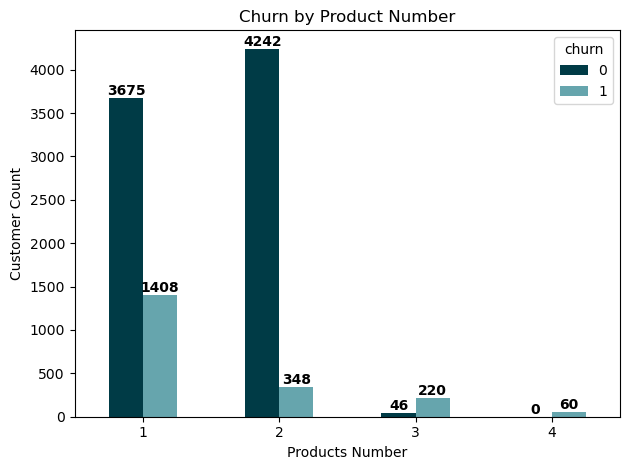

In [17]:
#Product Number vs customer churn count

count_data = customer_churn_data.groupby(['products_number', 'churn']).size().reset_index(name='count')
pivot_data = count_data.pivot(index='products_number', columns='churn', values='count').fillna(0)
palette = ["#003b46","#66a5ad", "#800000","#c4dfe6","#f59e0b", "#fcb646"]


ax = pivot_data.plot(kind='bar', stacked=False, color=palette)
plt.xlabel('Products Number')
plt.ylabel('Customer Count')
plt.title('Churn by Product Number')
plt.xticks(rotation=360)
plt.legend(title='churn', loc='upper right')
plt.tight_layout()

# Annotate each bar with count only
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')

# Show the plot
plt.show()


Observations: 

1. Over ~96% of the customers are either using 1 or 2 products from the bank 
2. But churn rate is higher in the people using >=3 products 

Insight:

1. Customers might be experiencing dissatisfaction with bundled services 
2. Managing and retaining customers using multiple products need effective customer engagement strategies 

## Factors that might not impact the churn rate of the customers 

<Figure size 1200x1200 with 0 Axes>

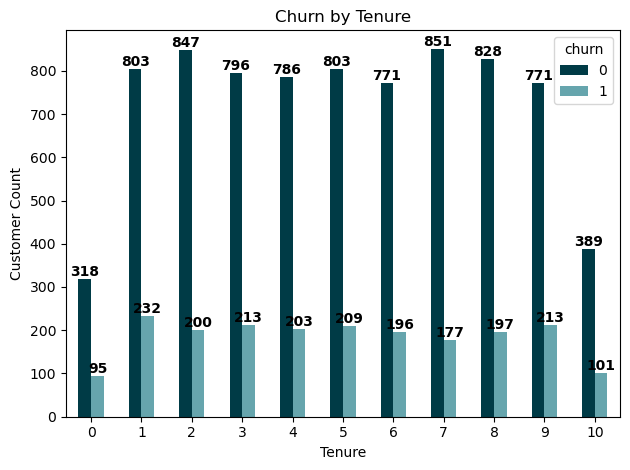

In [18]:
#Tenure vs customer churn count

count_data = customer_churn_data.groupby(['tenure', 'churn']).size().reset_index(name='count')
pivot_data = count_data.pivot(index='tenure', columns='churn', values='count').fillna(0)
palette = ["#003b46","#66a5ad", "#800000","#c4dfe6","#f59e0b", "#fcb646"]

plt.figure(figsize=(12, 12))
ax = pivot_data.plot(kind='bar', stacked=False, color=palette)
plt.xlabel('Tenure')
plt.ylabel('Customer Count')
plt.title('Churn by Tenure')
plt.xticks(rotation=360)
plt.legend(title='churn', loc='upper right')
plt.tight_layout()

# Annotate each bar with count only
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')
    

# Show the plot
plt.show()

Observations: 

1. Nearly equal proportions of customers can be found in each tenure
2. Churn Rate is nearly ~23% for almost all the tenures. Therefore Tenure has no impact on churn rate 

Insight:

1. Bank must have effectively segmented its customer base and addressed the needs of each segment leading to consistent churn      rates

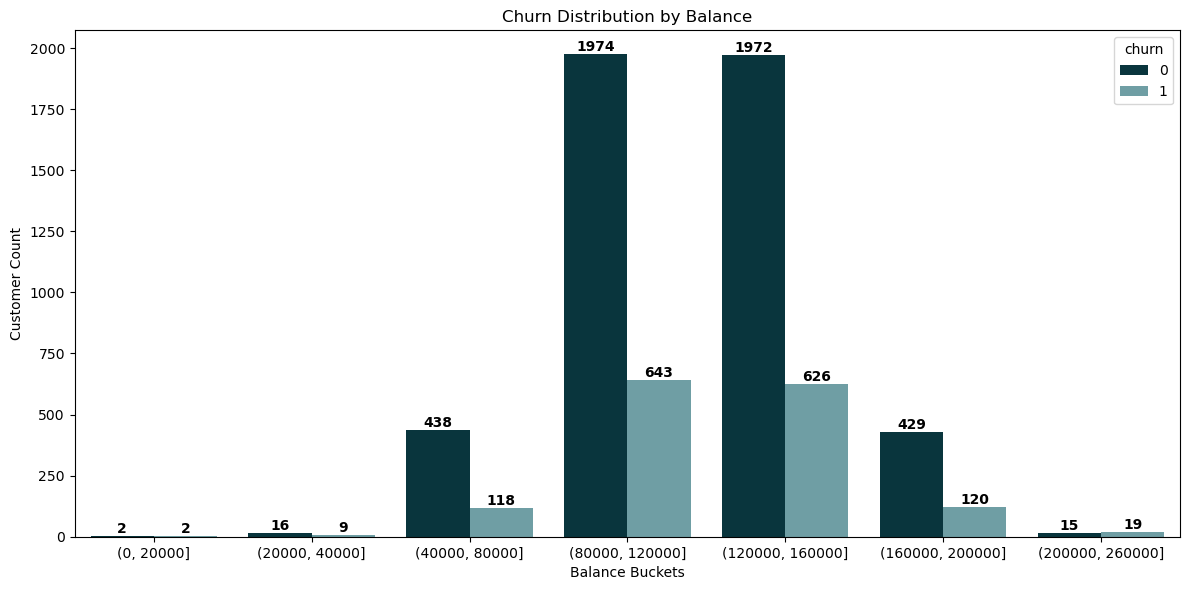

In [19]:
#Balance vs customer churn count

bins = [0, 20000, 40000, 80000, 120000,160000, 200000, 260000 ]
palette = ["#003b46","#66a5ad", "#800000","#c4dfe6","#f59e0b", "#fcb646"]
customer_churn_data['balance_bin'] = pd.cut(customer_churn_data['balance'], bins=bins)


# Bar plot for churn distribution within each balance bin
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='balance_bin', hue='churn', data=customer_churn_data,palette = palette)
plt.title('Churn Distribution by Balance')
plt.xlabel('Balance Buckets')
plt.ylabel('Customer Count')
plt.legend(title='churn', loc='upper right')
plt.tight_layout()

# Annotate each bar with count only
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')

plt.show()

Observations: 

1. Over ~52% of the customers are concentrated in the balance buckets of 80k-160k
2. And the churn rate is higher in the same buckets as well (~22%)

Insight: 

1. Account balance might not be the alone may not be the strong predictor of the churn rate

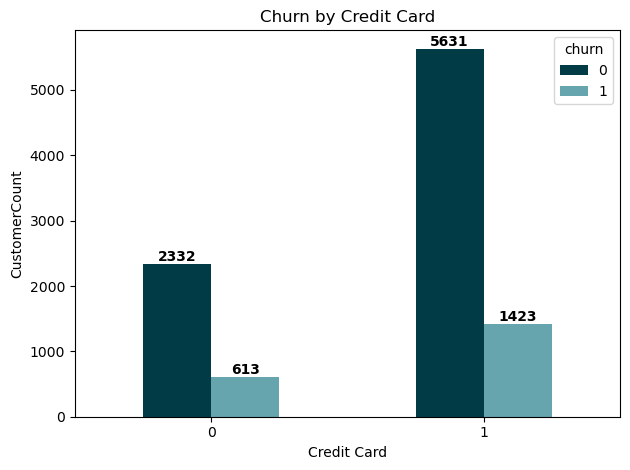

In [20]:
#Credit Card vs customer churn count

count_data = customer_churn_data.groupby(['credit_card', 'churn']).size().reset_index(name='count')
palette = ["#003b46","#66a5ad", "#800000","#c4dfe6","#f59e0b", "#fcb646"]

pivot_data = count_data.pivot(index='credit_card', columns='churn', values='count').fillna(0)
ax = pivot_data.plot(kind='bar', stacked=False, color=palette)
plt.xlabel('Credit Card')
plt.ylabel('CustomerCount')
plt.title('Churn by Credit Card')
plt.xticks(rotation=360)
plt.legend(title='churn', loc='upper right')
plt.tight_layout()

# Annotate each bar with count only
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')

# Show the plot
plt.show()


Observations: 

 1. Approximately 70% of the customers have credit cards but the churn rate (~20%) is almost similar for the ones who have credit cards and ones who don't 

Insight: 

 1. Presence or Absence of a credit card might not be a significant factor in customer churn


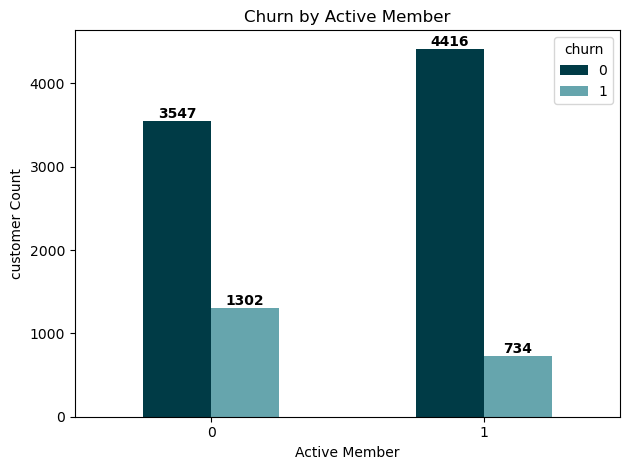

In [21]:
#Active Customer vs churn count

count_data = customer_churn_data.groupby(['active_member', 'churn']).size().reset_index(name='count')
pivot_data = count_data.pivot(index='active_member', columns='churn', values='count').fillna(0)
palette = ["#003b46","#66a5ad", "#800000","#c4dfe6","#f59e0b", "#fcb646"]

ax = pivot_data.plot(kind='bar', stacked=False, color=palette)
plt.xlabel('Active Member')
plt.ylabel('customer Count')
plt.title('Churn by Active Member')
plt.xticks(rotation=360)
plt.legend(title='churn', loc='upper right')
plt.tight_layout()

# Annotate each bar with count only
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')

# Show the plot
plt.show()

Observations: 

1. People who are not active are more likely to churn (~20% churn rate relatively greater than that of active members)

Insight: 

1. Non-Active members are likely to churn and that's matching with the usual scenario 

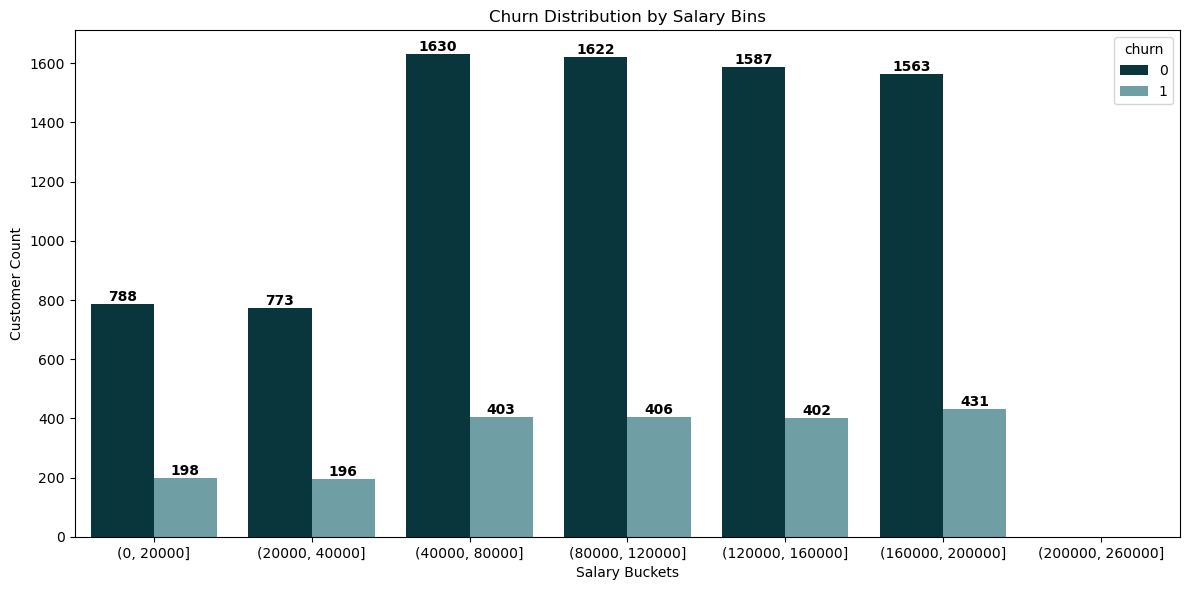

In [22]:
#Estimated Salary vs Customer Churn count

bins = [0, 20000, 40000, 80000, 120000,160000, 200000, 260000 ]
customer_churn_data['salary_bin'] = pd.cut(customer_churn_data['estimated_salary'], bins=bins)

plt.figure(figsize=(12, 6))

# Remove NaN values before creating the countplot
filtered_data = customer_churn_data.dropna(subset=['estimated_salary'])

ax = sns.countplot(x='salary_bin', hue='churn', data=filtered_data, palette=palette)
plt.title('Churn Distribution by Salary Bins')
plt.xlabel('Salary Buckets')
plt.ylabel('Customer Count')
plt.legend(title='churn', loc='upper right')
plt.tight_layout()

# Annotate each bar with count only
for p in ax.patches:
    count = int(p.get_height()) if not pd.isna(p.get_height()) else 0
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')

# Show the plot
plt.show()


#Observations: 

1. Most of the customers have salary in the range of 40k and 200k
Insight: 

1. Almost all the customers in different salary buckets have same churn rate (~20%) indicating that the salary alone might not be a factor for churn

# 3.2 Bi-Variate/Multi-Variate Analysis

C:\Users\satya\AppData\Local\Temp\ipykernel_43472\3394808984.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='country', y='count', hue='gender', data=churned_data, palette=palette, ci=None)


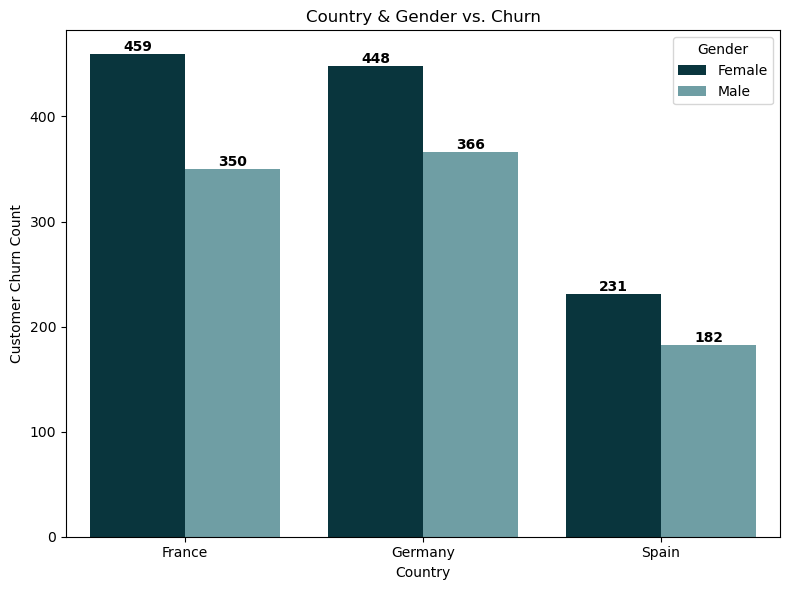

In [25]:
#Country & Gender Vs. Churn

#This Python code uses matplotlib and seaborn to show how customer churn relates to country and gender. 
#It creates a bar plot to display churn counts across countries and genders, using a color palette to 
#highlight gender differences in churn patterns

palette = ["#003b46", "#66a5ad", "#c4dfe6", "#800000", "#f59e0b", "#fcb646"]
grouped_data = customer_churn_data.groupby(['country', 'gender', 'churn']).size().reset_index(name='count')
churned_data = grouped_data[grouped_data['churn'] == 1]

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='country', y='count', hue='gender', data=churned_data, palette=palette, ci=None)
plt.title('Country & Gender vs. Churn')
plt.xlabel('Country')
plt.ylabel('Customer Churn Count')
plt.legend(title='Gender', loc='upper right')
plt.tight_layout()

# Annotate each bar with count only for churned customers
for p in ax.patches:
    count = int(p.get_height()) if not pd.isna(p.get_height()) else 0
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')

plt.show()

Observation: 
1. There is high churn rate in females in all countries.
2. France and Germany, have similar churn rate

Insights:
1. The bank needs to analyse what is causing a negative sentiment among women to churn out.
2. France and Germany possibly have a competitive market, with a lot of eligible players acquiring the customers

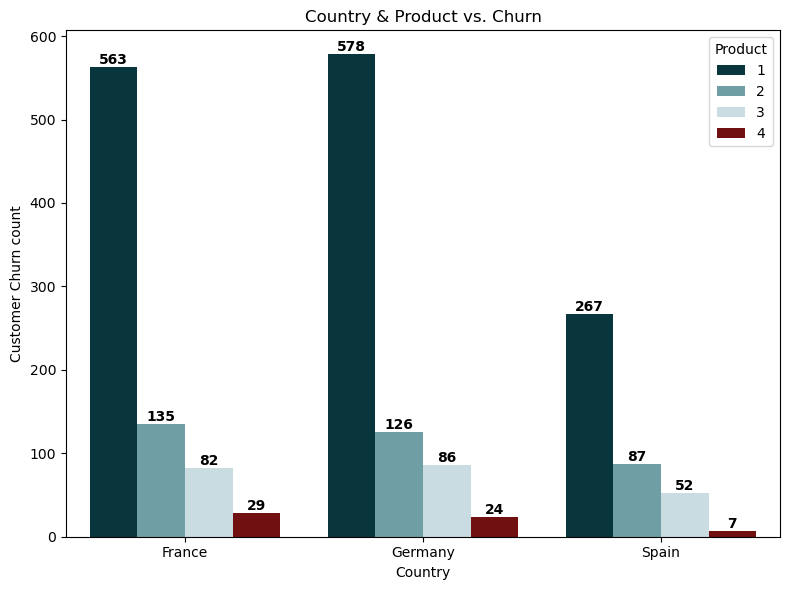

In [28]:
#Country & Product Vs. Churn

custom_palette = ["#003b46", "#66a5ad", "#c4dfe6", "#800000", "#f59e0b", "#fcb646"]
grouped_data_product = customer_churn_data.groupby(['country', 'products_number', 'churn']).size().reset_index(name='count')

# Filter for churned data
churned_data_product = grouped_data_product[grouped_data_product['churn'] == 1]

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='country', y='count', hue='products_number', data=churned_data_product, palette=custom_palette)
plt.title('Country & Product vs. Churn')
plt.xlabel('Country')
plt.ylabel('Customer Churn count')
plt.legend(title='Product', loc='upper right')
plt.xticks(rotation=360)
plt.tight_layout()

# Annotate each bar with count for churned customers
for p in ax.patches:
    count = int(p.get_height()) if not pd.isna(p.get_height()) else 0
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black', weight='bold')

plt.show()


Observations: 
1. Product 1 - has a very high churn rate across countries
2. Germany and France-Both have similar churn rates for all products
3. Spain - Has relatively less churn rate compared to France and Germany

Insights:
1. The policies of the Governement in France and Germany , may not be in sync- which might be causing the high churn.
2. The Bank also needs to take closer look on the marketing- advertising strategies and Customer Satisfaction

# 4. Classification using ML models

In [ ]:
#Drop all the bin columns created

customer_churn_data= customer_churn_data.drop('age_bucket', axis=1)
customer_churn_data= customer_churn_data.drop('balance_bin', axis=1)
customer_churn_data= customer_churn_data.drop('salary_bin', axis=1)

In [29]:
#Random Forest

warnings.filterwarnings("ignore")

y = customer_churn_data['churn']
X = customer_churn_data.drop('churn', axis=1)
X = pd.get_dummies(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Convert confusion matrix and classification report to DataFrames
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
classification_rep_df = pd.DataFrame.from_dict(classification_report(y_test, y_pred, output_dict=True)).round(2)

# Print the results
print(f'Accuracy: {accuracy*100}')
print('\nConfusion Matrix:')
display(conf_matrix_df)
print('\nClassification Report:')
classification_rep_df

Accuracy: 85.6

Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,1551,58
Actual Positive,230,161



Classification Report:


,0,1,accuracy,macro avg,weighted avg
precision,0.87,0.74,0.86,0.80,0.84
recall,0.96,0.41,0.86,0.69,0.86
f1-score,0.92,0.53,0.86,0.72,0.84
support,1609.00,391.00,0.86,2000.00,2000.00


In [30]:
#KNN Classifier

warnings.filterwarnings("ignore")

y = customer_churn_data['churn']
X = customer_churn_data.drop('churn', axis=1)
X = pd.get_dummies(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5) 
knn_classifier.fit(X_train_scaled, y_train)
y_pred = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
classification_rep_df = pd.DataFrame.from_dict(classification_report(y_test, y_pred, output_dict=True)).round(2)

print("Accuracy:", accuracy*100)
print("\nClassification Report:")
display(conf_matrix_df)
display(classification_rep_df)


Accuracy: 81.2

Classification Report:


,Predicted Negative,Predicted Positive
Actual Negative,1526,83
Actual Positive,293,98


,0,1,accuracy,macro avg,weighted avg
precision,0.84,0.54,0.81,0.69,0.78
recall,0.95,0.25,0.81,0.60,0.81
f1-score,0.89,0.34,0.81,0.62,0.78
support,1609.00,391.00,0.81,2000.00,2000.00


In [31]:
#Logistic Regression

#Splitting the data into train and test
y = customer_churn_data['churn']
X = customer_churn_data.drop('churn', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Pre-processing Data
numeric_features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']
categorical_features = ['country', 'gender']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[ ('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])

#logistic regression
pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LogisticRegression(max_iter=1000))])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
classification_rep_df = pd.DataFrame.from_dict(classification_report(y_test, y_pred, output_dict=True)).round(2)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}')
display(conf_matrix_df)
classification_rep_df

Accuracy: 80.77


,Predicted Negative,Predicted Positive
Actual Negative,2328,101
Actual Positive,476,95


,0,1,accuracy,macro avg,weighted avg
precision,0.83,0.48,0.81,0.66,0.76
recall,0.96,0.17,0.81,0.56,0.81
f1-score,0.89,0.25,0.81,0.57,0.77
support,2429.00,571.00,0.81,3000.00,3000.00


In [32]:
#Ridge and Lasso Regression

#Splitting the data into train and test
y = customer_churn_data['churn']
X = customer_churn_data.drop('churn', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Pre-processing Data
numeric_features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']
categorical_features = ['country', 'gender']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[ ('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])


# Creating pipelines with preprocessing and logistic regression with Lasso (L1) and Ridge (L2)
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))])
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000))])
lasso_pipeline.fit(X_train, y_train)

#Making Predictions with the designed model
ridge_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)
y_pred_ridge = ridge_pipeline.predict(X_test)

# Evaluating the models
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
print(f'Accuracy Lasso: {accuracy_lasso*100:.2f}')
print(f'Accuracy Ridge: {accuracy_ridge*100:.2f}')


conf_matrix_lasso = confusion_matrix(y_test, y_pred_lasso)
conf_matrix_df_lasso = pd.DataFrame(conf_matrix_lasso, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
conf_matrix_ridge = confusion_matrix(y_test, y_pred_ridge)
conf_matrix_df_ridge = pd.DataFrame(conf_matrix_ridge, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
classification_rep_df_lasso = pd.DataFrame.from_dict(classification_report(y_test, y_pred_lasso, output_dict=True)).round(2)
classification_rep_df_ridge = pd.DataFrame.from_dict(classification_report(y_test, y_pred_ridge, output_dict=True)).round(2)



print('\nConfusion Matrix for Lasso:')
display(conf_matrix_df_lasso)

print('\nConfusion Matrix for Ridge:')
display(conf_matrix_df_ridge)

# Classification Report for Lasso
print("Classification Report for Lasso:")
display(classification_rep_df_lasso)


# Classification Report for Ridge
print("Classification Report for Ridge:")
display(classification_rep_df_ridge)


Accuracy Lasso: 80.83
Accuracy Ridge: 80.77

Confusion Matrix for Lasso:


,Predicted Negative,Predicted Positive
Actual Negative,2329,100
Actual Positive,475,96



Confusion Matrix for Ridge:


,Predicted Negative,Predicted Positive
Actual Negative,2328,101
Actual Positive,476,95


Classification Report for Lasso:


,0,1,accuracy,macro avg,weighted avg
precision,0.83,0.49,0.81,0.66,0.77
recall,0.96,0.17,0.81,0.56,0.81
f1-score,0.89,0.25,0.81,0.57,0.77
support,2429.00,571.00,0.81,3000.00,3000.00


Classification Report for Ridge:


,0,1,accuracy,macro avg,weighted avg
precision,0.83,0.48,0.81,0.66,0.76
recall,0.96,0.17,0.81,0.56,0.81
f1-score,0.89,0.25,0.81,0.57,0.77
support,2429.00,571.00,0.81,3000.00,3000.00
